# Russian entity-based sentiment analysis using BERT

Попробуем классифицировать по CLS токену, а на само слово навешивать маску.


In [1]:
!wget https://raw.githubusercontent.com/named-entity/hse-nlp/master/4th_year/Project/train_aspects.txt
!wget https://raw.githubusercontent.com/named-entity/hse-nlp/master/4th_year/Project/train_reviews.txt
!wget https://raw.githubusercontent.com/named-entity/hse-nlp/master/4th_year/Project/dev_reviews.txt
!wget https://raw.githubusercontent.com/aaaksenova/NLP_ABSA_project/change/data/dev_pred_aspects.txt

--2021-12-27 12:49:26--  https://raw.githubusercontent.com/named-entity/hse-nlp/master/4th_year/Project/train_aspects.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 228391 (223K) [text/plain]
Saving to: ‘train_aspects.txt.3’

train_aspects.txt.3 100%[===================>] 223.04K  --.-KB/s    in 0.01s   

2021-12-27 12:49:26 (19.3 MB/s) - ‘train_aspects.txt.3’ saved [228391/228391]

--2021-12-27 12:49:26--  https://raw.githubusercontent.com/named-entity/hse-nlp/master/4th_year/Project/train_reviews.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.110.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting re

In [2]:
!pip install transformers

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import bs4
import os
from tqdm.notebook import tqdm
sns.set(font_scale=1.4)

import torch
from torch import nn
from torch.utils.data import DataLoader

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score

from transformers import AutoModel, AutoTokenizer, AdamW,\
                        get_linear_schedule_with_warmup

In [4]:
import random 

random_seed = 207
random_state = random_seed

def set_seed_everywhere(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    torch.cuda.manual_seed_all(seed)

set_seed_everywhere(random_seed)

In [5]:
aspects = pd.read_csv('train_aspects.txt', sep='\t', header=None)
aspects.columns = ['sentence_id', 'tag', 'term', 'from', 'to', 'sentiment']
reviews = pd.read_csv('train_reviews.txt',sep='\t', header=None)
reviews.columns = ['sentence_id', 'text']

pred_aspects = pd.read_csv('dev_pred_aspects.txt', sep='\t', header=None)
pred_aspects.columns = ['sentence_id', 'tag', 'term', 'from', 'to']
dev_reviews = pd.read_csv('dev_reviews.txt',sep='\t', header=None)
dev_reviews.columns = ['sentence_id', 'text']

In [6]:
data_train = aspects.merge(reviews, on='sentence_id')
data_dev = pred_aspects.merge(dev_reviews, on='sentence_id')

Загрузим данные:

In [7]:
USE_GPU = True

if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

print('using device:', device)

using device: cuda


In [8]:
data_train.head()

,sentence_id,tag,term,from,to,sentiment,text
0,3976,Whole,ресторане,71,80,neutral,"День 8-го марта прошёл, можно и итоги подвести..."
1,3976,Whole,ресторанах,198,208,neutral,"День 8-го марта прошёл, можно и итоги подвести..."
2,3976,Whole,ресторане,256,265,neutral,"День 8-го марта прошёл, можно и итоги подвести..."
3,3976,Service,Столик бронировали,267,285,neutral,"День 8-го марта прошёл, можно и итоги подвести..."
4,3976,Service,администратор,322,335,positive,"День 8-го марта прошёл, можно и итоги подвести..."


In [9]:
data_train['sentiment'].unique()

array(['neutral', 'positive', 'both', 'negative'], dtype=object)

Создадим датасет:

In [33]:
sentiment_vocab = {'negative': 0, 'positive': 1, 'neutral': 2, 'both': 3}

class Dataset():

    def __init__(self, data, test=False):
        self.data = data
        self.test = test

    def __getitem__(self, index):
        text = self.data['text'].values[index]
        if not self.test:
          sentiment = self.data['sentiment'].values[index]
        masked_text = (
            text[:self.data['from'].values[index]] + 
            '[MASK]' + 
            text[self.data['to'].values[index]:]
        )
        if not self.test:
          return masked_text, sentiment_vocab[sentiment]
        else:
          return masked_text

    def __len__(self):
        return len(self.data)

In [34]:
train_data, val_data = train_test_split(data_train, test_size=0.25)

train_dataset = Dataset(train_data)
val_dataset = Dataset(val_data)
test_dataset = Dataset(data_dev, test=True)

Загрузим BERT:

In [12]:
# Store the model we want to use
MODEL_NAME = "cointegrated/rubert-tiny"

# We need to create the model and tokenizer
model = AutoModel.from_pretrained(
    MODEL_NAME
)

tokenizer = AutoTokenizer.from_pretrained(
    MODEL_NAME, 
    do_lower_case=True
)

Some weights of the model checkpoint at cointegrated/rubert-tiny were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.decoder.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Зададим классификатор:

In [13]:
class Classifier(nn.Module):

    def __init__(self, bert):
        super().__init__()
        self.bert = bert
        self.dropout = nn.Dropout(p=0.3)
        self.linear_1 = nn.Linear(312, 4)
        #self.linear_1 = nn.Linear(768, 4)
        self.softmax = nn.Softmax()

    def forward(self, x, attention_mask=None):
        output  = self.bert(
            x, attention_mask=attention_mask
        )
        x = output['last_hidden_state'][:, 0]
        x = self.dropout(x)
        x = self.linear_1(x)
        x = self.softmax(x)
        return x

Зададим условия для тренировки:

In [14]:
model_classifier = Classifier(model).cuda()

n_epoch = 6
batch_size = 4

train_loss = []
val_loss = []

train_dataloader = DataLoader(train_dataset, batch_size=batch_size)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size)
criterion = nn.CrossEntropyLoss()

In [15]:
optimizer = AdamW(
    model.parameters(),
    weight_decay = 1e-6, 
    lr = 2e-6, 
    eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
)

train_scheduler = get_linear_schedule_with_warmup(
    optimizer, 
    num_warmup_steps = 1, # Default value in run_glue.py
    num_training_steps = len(train_dataloader) * n_epoch
)

Начнем тренировку модели:

In [16]:
for epoch in tqdm(range(n_epoch)):
    model_classifier.train()
    current_train_loss = 0
    for text, y in tqdm(train_dataloader, leave=False):
        tokens = tokenizer.batch_encode_plus(
            list(text),
            pad_to_max_length=True,
            return_tensors='pt'
        )

        logits = model_classifier(
            tokens['input_ids'].cuda(),
            attention_mask=tokens['attention_mask'].cuda()            
        )

        loss = criterion(logits, y.cuda())
        current_train_loss += loss.item()

        optimizer.zero_grad()

        loss.backward()

        # избавимся от взрывающихся градиентов
        nn.utils.clip_grad_norm_(
            model_classifier.parameters(), 
            1.0
        )

        optimizer.step()
        train_scheduler.step()
        

    train_loss.append(current_train_loss / len(train_dataloader))

    model_classifier.eval()
    current_val_loss = 0
    predictions = []
    actuals = []
    for text, y in val_dataloader:

        tokens = tokenizer.batch_encode_plus(
            list(text),
            pad_to_max_length=True,
            return_tensors='pt'
        )

        logits = model_classifier(
            tokens['input_ids'].cuda(),
            attention_mask=tokens['attention_mask'].cuda()    
        )
        loss = criterion(logits, y.cuda())
        current_val_loss += loss.item()

        predictions += list(logits.argmax(axis=1).data.cpu().numpy())
        actuals += list(y.data.cpu().numpy())

    print('Accuracy:', accuracy_score(actuals, predictions))    
    val_loss.append(current_val_loss / len(val_dataloader))

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/893 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2232: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Accuracy: 0.6515533165407221


  0%|          | 0/893 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2232: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Accuracy: 0.6515533165407221


  0%|          | 0/893 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2232: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Accuracy: 0.6515533165407221


  0%|          | 0/893 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2232: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Accuracy: 0.6515533165407221


  0%|          | 0/893 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2232: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Accuracy: 0.6515533165407221


  0%|          | 0/893 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2232: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Accuracy: 0.6515533165407221


In [17]:
from sklearn.metrics import accuracy_score

Посмотрим, как вел себя лосс в процессе обучения:

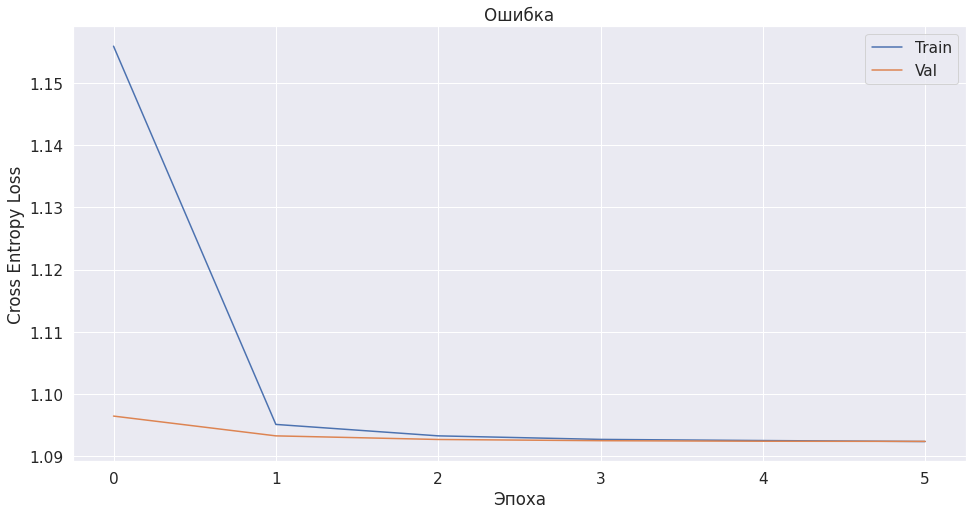

In [18]:
plt.figure(figsize=(16, 8))

plt.plot(train_loss, label='Train')
plt.plot(val_loss, label='Val')
plt.title('Ошибка')
plt.xlabel('Эпоха')
plt.ylabel('Cross Entropy Loss')
plt.legend()

plt.show()

Посомтрим на точность:

In [19]:
model_classifier.cuda();

In [36]:
test_dataloader = DataLoader(
    test_dataset, batch_size=3
)

predictions = []

model_classifier.eval()

for text in tqdm(test_dataloader):

    tokens = tokenizer.batch_encode_plus(
        text,
        pad_to_max_length=True,
        return_tensors='pt'
    )

    logits = model_classifier(
        tokens['input_ids'].cuda(),
        attention_mask=tokens['attention_mask'].cuda()   
    ).argmax(dim=1)
    
    predictions += list(logits.data.cpu().numpy())

  0%|          | 0/374 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2232: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


In [41]:
data_dev['predictions'] = predictions

In [45]:
to_sent = {v:k for k, v in sentiment_vocab.items()}

In [47]:
data_dev['predictions'] = data_dev['predictions'].apply(lambda x: to_sent[x])

In [49]:
data_dev.to_csv('entity_based.csv')

In [52]:
data_dev = data_dev[['sentence_id', 'tag', 'term', 'from', 'to', 'predictions']]

In [79]:
data_dev.to_csv('dev_pred_aspects.txt',sep='\t', header=False, index=False)

In [69]:
data_dev

,sentence_id,tag,term,from,to,predictions
0,13823,Whole,аппетит,7,16,positive
1,13823,Service,встретил,138,146,positive
2,13823,Service,менеджер,147,155,positive
3,13823,Service,девушка,179,186,positive
4,13823,Service,проводила к столу,188,205,positive
...,...,...,...,...,...,...
1115,11770,Food,стейк,831,836,positive
1116,11770,Food,блюдо тартар с сырой рыбой и сырым яйцом,896,936,positive
1117,11770,Service,Официанты,938,947,positive
1118,11770,Service,обстановкая,976,987,positive


In [74]:
from collections import Counter

CATEGORIES = ['Whole', 'Interior', 'Service', 'Food', 'Price']
def get_full_sentiment(df):
    out = []
    for ind in df.sentence_id.unique():
        text_categories = df[df.sentence_id==ind][['tag', 'predictions']].groupby('tag')
        asp_counter = {cat: Counter(vals['predictions'].values) for cat, vals in text_categories}
        for c in CATEGORIES:
            if c not in asp_counter:
                s = 'absence'
            elif len(asp_counter[c]) == 1:
                s = asp_counter[c].most_common(1)[0][0]
            else:
                s = 'both'
            out.append([ind, c, s])
    return pd.DataFrame(out, columns=['sentence_id', 'tag', 'predictions'])

In [75]:
text_sents = get_full_sentiment(data_dev)

In [78]:
text_sents.to_csv('dev_pred_cats.txt', sep='\t', header=False, index=False)